In [1]:
import matplotlib.pyplot as plt
import copy
from skimage import draw
import numpy as np
import torch
import random
from skimage.metrics import structural_similarity as ssim
from methods import BayesianTomography, EvidenceLoss, RMSELoss

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['font.size'] = 9
plt.rcParams['axes.linewidth'] = 1.0

torch.manual_seed(5)
np.random.seed(5)
random.seed(5)
D_DIM = 12  # detector dimensition
F_DIM = 64  # reconstructed image dimenstion
NOISE_RATE = 0.125
KERNEL = "NS"  # switch between nonstationary("NS") and stationary("SE")
norm = 0.8  # pixel distance ratio
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

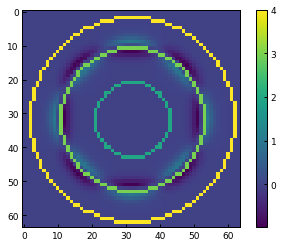

In [2]:
def mk_ls_image(f, radius_list):
    for i, radius in enumerate(radius_list):
        rr, cc = draw.circle_perimeter(int(F_DIM / 2), int(F_DIM / 2), radius=radius, shape=f.shape)
        f[rr, cc] = i + 2
    return f


# d = Rf
R = np.load(f"R_{D_DIM}_{F_DIM}.npy")
f = np.load(f"f_{F_DIM}.npy")[:, ::-1]
d = R.dot(f.flatten())
radius_list = [11, 21, 30]  # hyperprameters of magnetic surface
ls_image = mk_ls_image(copy.deepcopy(f), radius_list)
model = BayesianTomography(R=R, d=d, ls_img=ls_image, radius_list=radius_list, device=device, noise_rate=NOISE_RATE, kernel=KERNEL, norm=norm)
train_y_img = torch.tensor(f.flatten())
train_y_img = train_y_img.to(device, dtype=torch.float32)

loss_function2 = RMSELoss()
loss_function = EvidenceLoss()
plt.imshow(ls_image)
plt.colorbar()

In [3]:
optimizer = torch.optim.Adam([
    {'params': model.parameters()},

], lr=0.07)

model.train()
training_iter = 15
prev_loss = 100000000
prev_loss_img = 1000000000
for i in range(training_iter):
    optimizer.zero_grad()
    model()
    if torch.isnan(model.d_mu).any():
        print("BREAK!!")
        break
    loss = loss_function(model)
    loss_img = loss_function2(model.f_mu, train_y_img)
    print(f"loss_img:{loss_img.item():.3f},minus_evidence:{loss.item():.0f}")
    if prev_loss > loss and loss > 0:
        print("updated")
        prev_model = model
        prev_loss = loss
        prev_loss_img = loss_img
    loss.backward(retain_graph=True)
    optimizer.step()
for n, p in prev_model.named_parameters():
    print(n, p)

loss_img:0.187,minus_evidence:751
updated
loss_img:0.187,minus_evidence:731
updated
loss_img:0.186,minus_evidence:709
updated
loss_img:0.185,minus_evidence:686
updated
loss_img:0.184,minus_evidence:661
updated
loss_img:0.183,minus_evidence:635
updated
loss_img:0.182,minus_evidence:608
updated
loss_img:0.180,minus_evidence:578
updated
loss_img:0.179,minus_evidence:550
updated
loss_img:0.177,minus_evidence:523
updated
loss_img:0.176,minus_evidence:505
updated
loss_img:0.177,minus_evidence:514
loss_img:0.177,minus_evidence:547
loss_img:0.177,minus_evidence:541
loss_img:0.177,minus_evidence:520
ls Parameter containing:
tensor([0.0799, 1.6112, 0.0224], device='cuda:0', requires_grad=True)
l_se Parameter containing:
tensor(1.8517, requires_grad=True)
sigma_se Parameter containing:
tensor(0.2768, requires_grad=True)
sigma_ns Parameter containing:
tensor(0.2472, requires_grad=True)


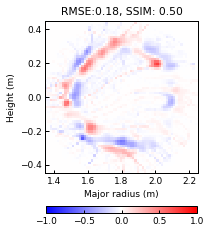

In [4]:
out_f = prev_model.f_mu.detach().cpu().numpy().reshape(*f.shape)
rmse_loss = prev_loss_img.detach().cpu().numpy()
ssim_loss = ssim(out_f, f,
                 data_range=f.max() - f.min())
plt.axes().set_aspect('equal')
plt.title(f"RMSE:{rmse_loss:.2f}, SSIM: {ssim_loss:.2f}")
y = np.linspace(-0.45, 0.45, F_DIM)
x = np.linspace(1.35, 2.25, F_DIM)
X, Y = np.meshgrid(x, y)
plt.ylabel("Height (m)")
plt.xlabel("Major radius (m)")
plt.pcolor(X, Y, out_f, cmap="bwr", vmax=1., vmin=-1.)
plt.colorbar(orientation="horizontal", shrink=0.45)
plt.savefig(f"{KERNEL}_{D_DIM}_{NOISE_RATE:.2f}.png")

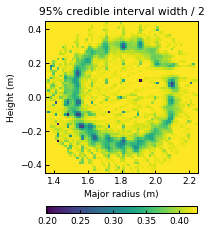

<Figure size 432x288 with 0 Axes>

In [5]:
post_cov = prev_model.post_cov.detach().cpu().numpy()
cov = np.sqrt(np.diag(post_cov).reshape(*f.shape)) * 1.96
plt.axes().set_aspect('equal')
plt.title("95% credible interval width / 2")
plt.ylabel("Height (m)")
plt.xlabel("Major radius (m)")
plt.pcolor(X, Y, cov)
plt.colorbar(orientation="horizontal", shrink=0.45)
plt.show()
plt.savefig(f"{KERNEL}_{D_DIM}_sigma.png")

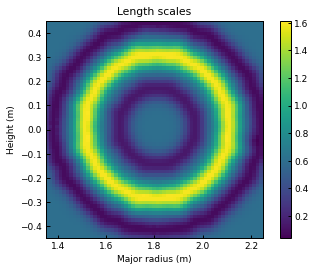

In [6]:
if KERNEL == 'NS':
    plt.axes().set_aspect('equal')
    plt.title("Length scales")
    l_all = prev_model.l_all.detach().cpu().numpy().reshape(*f.shape)
    plt.pcolor(X, Y, l_all)
    plt.colorbar()
    plt.ylabel("Height (m)")
    plt.xlabel("Major radius (m)")
    plt.savefig("optimized_l.png")

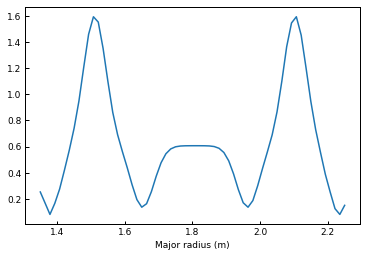

In [7]:
if KERNEL == 'NS':
    x = np.linspace(1.35, 2.25, F_DIM)
    plt.plot(x, l_all[32, :])
    plt.xlabel("Major radius (m)")